## Building block preparation
 **bbSelect** should have compounds filtered to desirable substructures, and requires data against each compound to instruct the prioritisation.
 - This notebook calculates a number of simple properties for the enamine acids and combines these into a composite score referred to as the bbComplexity score
 - Also, published substructure filters are used to filter the compounds, and physicochemical filters are used to prune the input set 

In [1]:
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
import logging
import time
import numpy as np
import math

def linear_MPO(values, low, high, mode='max'):
    
    values = values.astype(float)
    slope = 1/(high-low)
    values = values.to_numpy()
    values = np.piecewise(values, [(low <= values)&(values <= high), values < low, values > high],[lambda x: (x-low)*slope, 0, 1])
    
    if mode == 'max':
        return values
    elif mode == 'min':
        return 1-values
    
    
def gaussian_MPO(values, center, deviation, mode='max', max_deviation_score=0.25):
    
    deviation_squared = deviation**2
    deviation_squared = deviation_squared*-1
    denominator = 2*math.log(max_deviation_score)
    c_squared = deviation_squared/denominator
    
    values = values-center
    values = values**2
    values = values*-1
    values = values/(2*c_squared)
    values = np.exp(values)
    
    if mode == 'max':
        return values
    
    elif mode == 'min':
        return 1-values
    
def sigmoid_MPO(values, center, deviation, mode='max', max_deviation_score=0.75):
    
    slope = math.log((1/max_deviation_score)-1)/(deviation)
    
    values = values-center
    values = values*slope
    values = np.exp(values)
    values = values+1
    values = values**-1
    
    if mode == 'max':
        return values
    
    elif mode == 'min':
        return 1-values
    

def combined_MPO(df, MPO_dict):
    
    overall_weightings = 0
    
    for prop in MPO_dict.keys():
        if MPO_dict[prop]['type'] == 'linear':
            df[f'{prop}_MPO'] = linear_MPO(
                values = df[prop], 
                low = MPO_dict[prop]['low'], 
                high = MPO_dict[prop]['high'], 
                mode = MPO_dict[prop]['mode'])
            
        elif MPO_dict[prop]['type'] == 'gaussian':
            df[f'{prop}_MPO'] = gaussian_MPO(
                values = df[prop], 
                center = MPO_dict[prop]['center'], 
                deviation = MPO_dict[prop]['deviation'], 
                mode = MPO_dict[prop]['mode'])            
        
        overall_weightings += MPO_dict[prop]['weight']
    
    total = np.sum([df[f'{prop}_MPO'] * MPO_dict[prop]['weight'] for prop in MPO_dict.keys()], axis = 0)

    #total = df[[f'{prop}_MPO' for prop in MPO_dict.keys()]].sum(axis = 1)

    df['MPO'] = 1 - (total / overall_weightings)
    
    return df

def get_simple_props(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    
    rb = rdMolDescriptors.CalcNumRotatableBonds(mol, strict = rdMolDescriptors.NumRotatableBondsOptions.Strict)
    mw = Descriptors.MolWt(mol)
    heavy = Descriptors.HeavyAtomCount(mol)
    chiral = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
    hbd = rdMolDescriptors.CalcNumHBD(mol)
    hba = rdMolDescriptors.CalcNumHBA(mol)
    heteroatom_count = rdMolDescriptors.CalcNumHeteroatoms(mol)
    rings = rdMolDescriptors.CalcNumRings(mol)
    rac = rdMolDescriptors.CalcNumUnspecifiedAtomStereoCenters(mol)
    clogp = Descriptors.MolLogP(mol)

    return {'rb' : rb, 'mw': mw, 'heavy' : heavy, 'chiral' : chiral, 'hba' : hba, 'hbd' : hbd, 'het_count' : heteroatom_count, 'rings' : rings, 'rac' : rac, 'clogp' : clogp}

def add_simple_props_to_dataframe(df, smiles_column = 'smiles'):

    ## Add simple properties to the data table
    start = time.time()
    
    for i, row in tqdm(df.iterrows(), total = df.shape[0]):
        simple_props = get_simple_props(row[smiles_column])

        for prop in simple_props.keys():
            df.loc[i,prop] = simple_props[prop]

    end = time.time()

    logging.info(f'Calculated properties in {end - start} seconds')
    
    return df



In [2]:
# Load in building blocks
enamine_acids = pd.read_csv('./data/enamine_acids/enamine_acids.csv')

# Define output_file

output_file = './data/enamine_acids/enamine_acids_filtered.csv'

In [3]:
# Calculate simple properties of the molecules. Do this first and filter because it is faster than substructure filtering.
enamine_acids = add_simple_props_to_dataframe(enamine_acids)

  0%|          | 0/44689 [00:00<?, ?it/s]

In [4]:
enamine_acids = enamine_acids[(enamine_acids['heavy'] < 15) & (enamine_acids['hbd'] < 4) & (enamine_acids['hba'] < 5) & (enamine_acids['rb'] < 5) & (enamine_acids['mw'] < 250)]

In [5]:
## Use published list of unwanted substructures for filtering
# https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T003_compound_unwanted_substructures
substructure_filter_file = './data/unwanted_substructures.csv'
substructures = pd.read_csv(substructure_filter_file, sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)

In [6]:
matches = []
clean = []

for index, row in tqdm(enamine_acids.iterrows(), total=enamine_acids.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "id": row.ID,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

enamine_acids = enamine_acids.loc[clean]

  0%|          | 0/23056 [00:00<?, ?it/s]

In [7]:
len(enamine_acids)

19280

In [8]:
## QED doesn't really work for building blocks but this is how you add it, should full molecules be used.
for i, row in enamine_acids.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    QED_props = Chem.QED.properties(mol)
    QED = Chem.QED.qed(mol)
    enamine_acids.loc[i, 'qed'] = QED
    
    if i == -1:
        break

In [9]:
MPO_dict = {
    'rb':{'low': 0, 'high':10, 'weight': 2, 'mode': 'min', 'type' : 'linear'},
    'mw':{'low': 60, 'high':300, 'weight': 1, 'mode': 'min', 'type' : 'linear'},
    'heavy':{'low': 5, 'high':20, 'weight': 1, 'mode': 'min', 'type' : 'linear'},
    'het_count': {'low':2, 'high':4, 'weight': 1, 'mode': 'min', 'type' : 'linear'},
    'hba': {'low':2, 'high':4, 'weight':1, 'mode' : 'min', 'type' : 'linear'},
    'hbd': {'low':1, 'high':4, 'weight':1, 'mode': 'min', 'type' : 'linear'},
    'rac': {'low':0, 'high':2, 'weight':1, 'mode': 'min', 'type' : 'linear'},
    'rings': {'center' : 1, 'deviation' : 3, 'weight':0.5, 'mode' : 'max', 'type' : 'gaussian'},
        }
enamine_acids = combined_MPO(enamine_acids, MPO_dict)

In [10]:
enamine_acids.sort_values('MPO', ascending = True).head(1000)

,smiles,ID,rb,mw,heavy,chiral,hba,hbd,het_count,rings,...,qed,rb_MPO,mw_MPO,heavy_MPO,het_count_MPO,hba_MPO,hbd_MPO,rac_MPO,rings_MPO,MPO
24686,CC(O)=O,EN300-31599,0.0,60.052,4.0,0.0,1.0,1.0,2.0,0.0,...,0.429883,1.0,0.999783,1.000000,1.0,1.0,1.0,1.0,0.857244,0.008423
25684,CC(O)=O,EN300-33471,0.0,60.052,4.0,0.0,1.0,1.0,2.0,0.0,...,0.429883,1.0,0.999783,1.000000,1.0,1.0,1.0,1.0,0.857244,0.008423
11681,CC(O)=O,EN300-18074,0.0,60.052,4.0,0.0,1.0,1.0,2.0,0.0,...,0.429883,1.0,0.999783,1.000000,1.0,1.0,1.0,1.0,0.857244,0.008423
15543,CC(O)=O,EN300-21631,0.0,60.052,4.0,0.0,1.0,1.0,2.0,0.0,...,0.429883,1.0,0.999783,1.000000,1.0,1.0,1.0,1.0,0.857244,0.008423
26134,CC(O)=O,EN300-345872,0.0,60.052,4.0,0.0,1.0,1.0,2.0,0.0,...,0.429883,1.0,0.999783,1.000000,1.0,1.0,1.0,1.0,0.857244,0.008423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,OC(=O)[C@@H]1CCC[C@@H]1c1ccccc1,EN300-39918708,2.0,190.242,14.0,2.0,1.0,1.0,2.0,2.0,...,0.777988,0.8,0.457325,0.400000,1.0,1.0,1.0,1.0,0.857244,0.189889
23668,Cc1cc(F)cc(C(O)=O)c1C,EN300-3038050,1.0,168.167,12.0,0.0,1.0,1.0,3.0,1.0,...,0.697048,0.9,0.549304,0.533333,0.5,1.0,1.0,1.0,1.000000,0.190278
38055,Cc1c(C)c(ccc1F)C(O)=O,EN300-7417211,1.0,168.167,12.0,0.0,1.0,1.0,3.0,1.0,...,0.697048,0.9,0.549304,0.533333,0.5,1.0,1.0,1.0,1.000000,0.190278
30598,Cc1cc(cc(C)c1F)C(O)=O,EN300-45418,1.0,168.167,12.0,0.0,1.0,1.0,3.0,1.0,...,0.697048,0.9,0.549304,0.533333,0.5,1.0,1.0,1.0,1.000000,0.190278


In [11]:
# Save filtered file

# Containing data for import
enamine_acids.to_csv(output_file, index = False)

<AxesSubplot:ylabel='Frequency'>

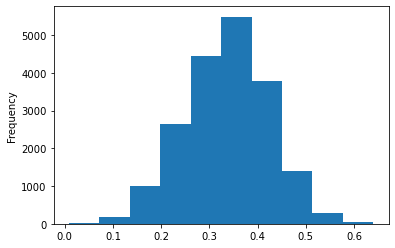

In [12]:
enamine_acids['MPO'].plot.hist()